# Street Network Analysis

based on osnmx and pandana
goals of the tutorial

- basic concepts of network analysis
- routing
- bearing

based on the open data of:
- OpenStreetMap

requirements
- python knowledge
- geopandas
- openstreetmap

status<br/>
“My Way”


---

# Setup
for this tutorial we will use [OSMnx](https://github.com/gboeing/osmnx) = (openstreetmap + [networkx](https://networkx.org/))

Boeing, G. 2017. "[OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks.](https://geoffboeing.com/publications/osmnx-complex-street-networks/)" *Computers, Environment and Urban Systems 65, 126-139. doi:10.1016/j.compenvurbsys.2017.05.004*



In [75]:
try:
    import pygeos
except ModuleNotFoundError as e:
    !pip install pygeos==0.13
    import pygeos

... and now we can install OSMnx

In [76]:
try:
    import osmnx  as ox
except ModuleNotFoundError as e:
    !pip install osmnx==1.2.2
      import osmnx  as ox
if ox.__version__ != "1.2.2":
    !pip install -U osmnx==1.2.2
    import osmnx  as ox

... and all the other packages needed for this lesson

In [77]:
try:
    import mapclassify
except ModuleNotFoundError as e:
    !pip install mapclassify
    import mapclassify

if mapclassify.__version__ != "2.4.3":
  !pip install -U mapclassify==2.4.3

In [78]:
try:
    import pyrosm
except ModuleNotFoundError as e:
    !pip install pyrosm==0.6.1
    import pyrosm

In [79]:
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore") 

# Let’s start with OSMnx


In [80]:
import osmnx as ox
import matplotlib.pyplot as plt

## prepare the data

... we can choose the same city used on the last tutorial 

[Venice in Italy](https://www.openstreetmap.org/relation/44230)

In [81]:
place_name = "Venezia, Lido, Venice, Venezia, Veneto, Italy"

.. and we can extract all the streets where it's possible to drive

OSMnx creates a overpass query to ask the data inside the area of name of the city and collect all the [highways](https://wiki.openstreetmap.org/wiki/Key:highway) where a car can move

Eg.<br/>
https://overpass-turbo.eu/s/1nnv

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/mezzolombardo_streets.png)

In [82]:
G = ox.graph_from_place(place_name, network_type='all')

OSMnx transform the data from OpenStreetMap in [graph](https://networkx.org/documentation/stable/reference/introduction.html#graphs) for [networkx](https://networkx.org/)

# Graph Theory
text from [wikipedia](https://en.wikipedia.org/wiki/Graph_theory)



A graph is made up of **vertices** (also called *nodes* or *points*) which are connected by **edges** (also called *links* or *lines*)

A distinction is made between undirected graphs, where edges link two vertices symmetrically, and directed graphs, where edges link two vertices asymmetrically;

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Undirected.svg/267px-Undirected.svg.png)

Example<br/>
undirected graph with three nodes and three edges. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a2/Directed.svg/267px-Directed.svg.png)

Example<br/>
a directed graph with three vertices and four directed edges<br/>(the double arrow represents an edge in each direction).


the type of graph generated by OSMnx is a MultiDiGraph: a directed graphs with self loops and parallel edges

more information [here](https://networkx.org/documentation/stable/reference/classes/multidigraph.html)

In [83]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

OSMnx converts the graph from latitude/longitude (WGS83) to the right UTM coordinate reference system for the area selected

In [84]:
G_proj = ox.project_graph(G)

from osmnx you can create geodataframes (gdfs) from a netxworkx Graph

In [85]:
gdfs = ox.graph_to_gdfs(G_proj)

In [86]:
type(gdfs)

tuple

0 => nodes (points)<br/>
1 => edges (lines)

In [87]:
type(gdfs[0])

geopandas.geodataframe.GeoDataFrame

In [88]:
gdfs[0].geometry.type.unique()

array(['Point'], dtype=object)

In [89]:
gdfs[1].geometry.type.unique()

array(['LineString'], dtype=object)

In [90]:
gdfs[1].crs

<Derived Projected CRS: +proj=utm +zone=33 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

extract only the nodes (projected)


In [91]:
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False, nodes=True)

In [92]:
type(nodes_proj)

geopandas.geodataframe.GeoDataFrame

In [93]:
nodes_proj.crs

<Derived Projected CRS: +proj=utm +zone=33 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

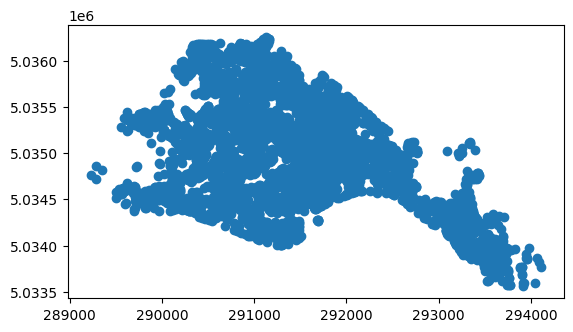

In [94]:
nodes_proj.plot()
plt.show()

In [95]:
lines_proj = ox.graph_to_gdfs(G_proj, nodes=False)

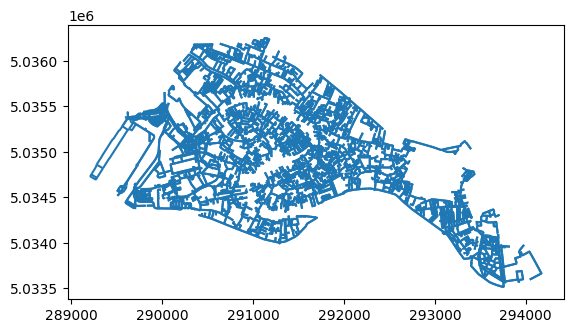

In [96]:
lines_proj.plot()
plt.show()

... and we can use it as a normal geodaframe<br/>

Eg:<br/>
what sized area does our network cover in square meters?

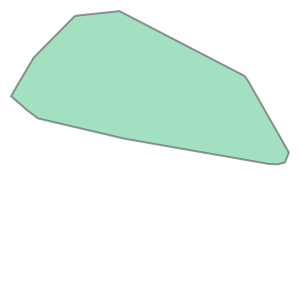

In [97]:
nodes_proj.unary_union.convex_hull

In [98]:
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

7679268.778717262

with OSMnx we can extract some basic statistics 

In [99]:
ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'n': 5020,
 'm': 12539,
 'k_avg': 4.995617529880478,
 'edge_length_total': 366879.9689999989,
 'edge_length_avg': 29.25910909960913,
 'streets_per_node_avg': 2.54003984063745,
 'streets_per_node_counts': {0: 0,
  1: 1359,
  2: 5,
  3: 3259,
  4: 382,
  5: 14,
  6: 0,
  7: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.2707171314741036,
  2: 0.00099601593625498,
  3: 0.649203187250996,
  4: 0.07609561752988048,
  5: 0.0027888446215139444,
  6: 0.0,
  7: 0.00019920318725099602},
 'intersection_count': 3661,
 'street_length_total': 186643.2119999999,
 'street_segment_count': 6355,
 'street_length_avg': 29.36950621557827,
 'circuity_avg': 1.0612066989278592,
 'self_loop_proportion': 0.0033044846577498033,
 'clean_intersection_count': 718,
 'node_density_km': 653.7080736010566,
 'intersection_density_km': 476.7380990943164,
 'edge_density_km': 47775.378043387376,
 'street_density_km': 24304.81565084334,
 'clean_intersection_density_km': 93.49848542740213}

stats documentation: [https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats)

## Glossary of the terms used by the statistics

For a complete list look the [networkx documentation](https://networkx.org/documentation/stable/)

- **density**<br/>defines the density of a graph. The density is 0 for a graph without edges and 1 for a complete graph. The density of multigraphs can be higher than 1.
- **center**<br/>is the set of points with eccentricity equal to radius.
- **betwnees centrality**<br/>is the number of possible interactions between two non-adjacent points
- **closeness centrality**<br/>is the average distance of a point from all the others
- **clustering coefficient**<br/>the measure of the degree to which points in a graph tend to cluster together
- **degree centrality**<br/>the number of lines incident upon a point 
- **eccentricity** <br/>the eccentricity of a point in a graph is defined as the length of a longest shortest path starting at that point
- **diameter**<br/>the maximum eccentricity
- **edge connectivity**<br/>
is equal to the minimum number of edges that must be removed to disconnect a graph or render it trivial.
- **node connectivity**<br/>
is equal to the minimum number of points that must be removed to disconnect a graph or render it trivial.
- **pagerank**<br/>
computes a ranking of the nodes (points) in a graph based on the structure of the incoming links (lines). It was originally designed as an algorithm to rank web pages.
- **periphery** <br/>is the set of nodes with eccentricity equal to the diameter
- **radius**<br/>is the minimum eccentricity.

... and we can plot the map

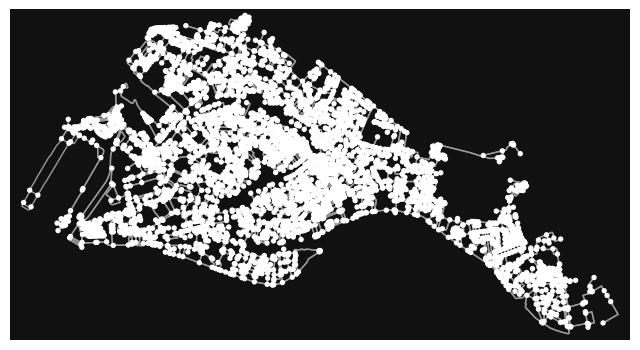

In [100]:
fig, ax = ox.plot_graph(G)
plt.show()

In [101]:
import networkx as nx

In [102]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, 'edge_centrality')

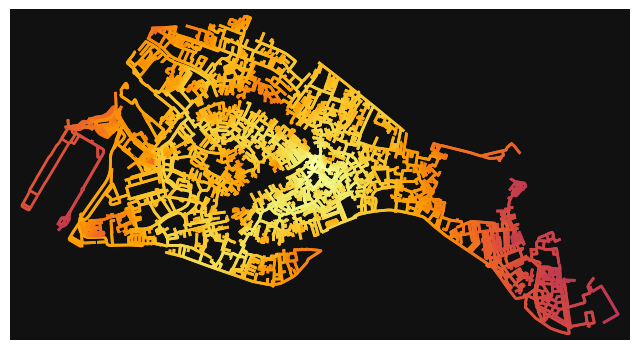

In [103]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, 'edge_centrality', cmap='inferno')
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)
plt.show()

# Find the shortest path between 2 points by minimizing travel time


## calculate the travel time for each edge

### define the origin and destination
Example:

from the train station of Venezia Santa Lucia to the Rialto Bridge


**train station**

[Venezia Santa Lucia](https://www.openstreetmap.org/node/6063641885)

lat: 45.4410753<br/>
lon: 12.3210322


**Rialto Bridge**

[Ponte di Rialto](https://www.openstreetmap.org/way/199258374)

lat: 45.43805<br/>
lon: 12.33593





## find the node on the graph nearest on the point given

thes two points are NOT on the graph.

We need to find the nodes nearest

In [104]:
point_nearest_train_station = ox.distance.nearest_nodes(G,Y=45.4410753,X=12.3210322)
point_nearest_bridge_rialto = ox.distance.nearest_nodes(G,Y=45.43805,X=12.33593)

In [105]:
# impute missing edge speeds and calculate edge travel times with the speed module
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)


### calculate the time to walk over each edges

In [106]:
G = ox.graph_from_place(place_name, network_type='walk')

plot the walkable street network

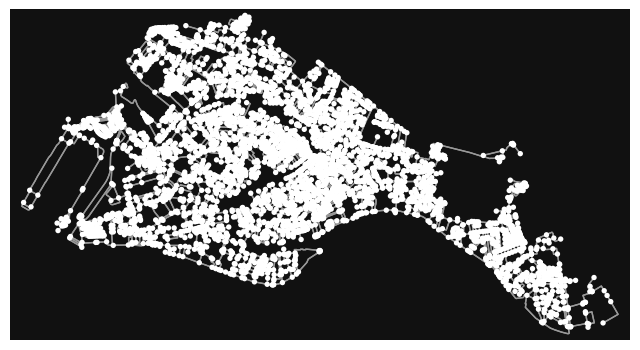

In [107]:
fig, ax = ox.plot_graph(G)
plt.show()

In [108]:
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

... geopandas investigation

In [109]:
edges = ox.graph_to_gdfs(G,edges=True,nodes=False)

In [110]:
edges.head(3)

osmid bridge             name  highway  oneway  \
u        v          key                                                       
27178184 764403528  0    166489461    yes  Ponte di Rialto  footway   False   
         1675825096 0    166489461    yes  Ponte di Rialto  footway   False   
         8670969688 0    450089474    yes  Ponte di Rialto    steps   False   

                        reversed  length  speed_kph  travel_time width  \
u        v          key                                                  
27178184 764403528  0      False   9.935       39.6          0.9   NaN   
         1675825096 0       True   5.120       39.6          0.5   NaN   
         8670969688 0      False   9.212       39.6          0.8     7   

                                                                  geometry  \
u        v          key                                                      
27178184 764403528  0    LINESTRING (12.33569 45.43820, 12.33561 45.43813)   
         1675825096 0    LINESTRING (12.33569 45.43820, 12.33573 45.43823)   
         8670969688 0    LINESTRING (12.33569 45.43820, 12.33560 45.43825)   

                        tunnel lanes maxspeed est_width access area service  \
u        v          key                                                       
27178184 764403528  0      NaN   NaN      NaN       NaN    NaN  NaN     NaN   
         1675825096 0      NaN   NaN      NaN       NaN    NaN  NaN     NaN   
         8670969688 0      NaN   NaN      NaN       NaN    NaN  NaN     NaN   

                        junction  
u        v          key           
27178184 764403528  0        NaN  
         1675825096 0        NaN  
         8670969688 0        NaN

In [111]:
edges.columns

Index(['osmid', 'bridge', 'name', 'highway', 'oneway', 'reversed', 'length',
       'speed_kph', 'travel_time', 'width', 'geometry', 'tunnel', 'lanes',
       'maxspeed', 'est_width', 'access', 'area', 'service', 'junction'],
      dtype='object')

In [112]:
edges[edges.travel_time == edges.travel_time.max()].name

u           v           key
1927219469  4068932557  0      NaN
4068932557  1927219469  0      NaN
Name: name, dtype: object

In [113]:
edges[edges.travel_time == edges.travel_time.max()].osmid

u           v           key
1927219469  4068932557  0      [404610512, 404610513]
4068932557  1927219469  0      [404610512, 404610513]
Name: osmid, dtype: object

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/osmid_3400471.jpg)

https://www.openstreetmap.org/way/404610513

## find the shortest path between the train station and Rialto bridge 

In [114]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, point_nearest_train_station, point_nearest_bridge_rialto, weight="travel_time")

In [115]:
route

[1927219479,
 3527986497,
 2493856508,
 9055796707,
 1921651801,
 27239442,
 5372700772,
 4899902714,
 1855450146,
 3371984917,
 2514483400,
 1858198295,
 1858198260,
 3371984290,
 3371984894,
 5360645772,
 1855473678,
 1855473687,
 4849873712,
 4849867342,
 1856706712,
 3389313497,
 5149979474,
 2732099927,
 4843929370,
 2732099913,
 2732099919,
 2732099909,
 2732099904,
 4803731379,
 4846061555,
 1857205293,
 1857205281,
 3392463459,
 1857205288,
 1856788519,
 3392463420,
 3392463416,
 1857148234,
 1840378080,
 2249214723,
 4803872602,
 4803871721,
 1857139330,
 4902225461,
 1857139271,
 1857139307,
 1857139318,
 1857139273,
 1857139324,
 1857139332,
 4983211717,
 4983211715,
 5649829357,
 5649829356,
 5649829355,
 4983211716,
 8670969688,
 27178184,
 5395065019]

these values are the ids of each node of the graph

In [116]:
G.nodes[5395065019]

{'y': 45.4380532, 'x': 12.3359319, 'street_count': 4}

In [117]:
nodes = ox.graph_to_gdfs(G,edges=False,nodes=True)

In [118]:
nodes

,y,x,street_count,highway,geometry
osmid,,,,,
27178184,45.438197,12.335686,4,NaN,POINT (12.33569 45.43820)
27178422,45.432325,12.337206,4,NaN,POINT (12.33721 45.43233)
27178433,45.429240,12.327350,3,NaN,POINT (12.32735 45.42924)
27178442,45.430846,12.320432,1,NaN,POINT (12.32043 45.43085)
27223839,45.434570,12.350321,3,NaN,POINT (12.35032 45.43457)
...,...,...,...,...,...
10108266854,45.437868,12.350362,3,NaN,POINT (12.35036 45.43787)
10118200318,45.431717,12.358683,3,NaN,POINT (12.35868 45.43172)
10118200319,45.431700,12.358617,3,NaN,POINT (12.35862 45.43170)


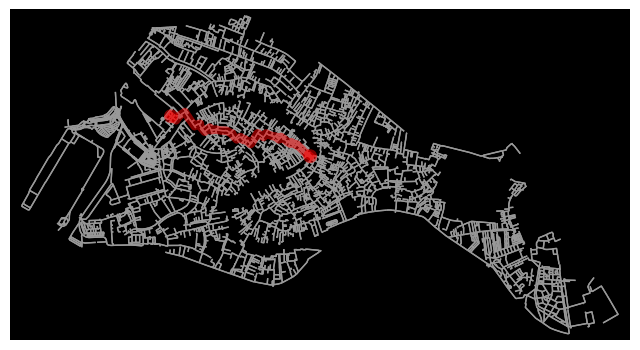

In [119]:
fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')
plt.show()


In [120]:
ox.plot_route_folium(G,route,popup_attribute='name',tiles='CartoDB dark_matter')
#OpenStreetMap
#Stamen Terrain
#Steman Toner
#Stamen Watercolor
#CartoDB positron
#CartoDB dark_matter

how long is our route in meters?

In [121]:
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, 'length')
sum(edge_lengths)

1614.4050000000004

how many minutes does it take?

In [122]:
import datetime

In [123]:
edge_times = ox.utils_graph.get_route_edge_attributes(G, route, 'travel_time')
seconds = sum(edge_times)

In [124]:
seconds

146.50000000000003

In [125]:
str(datetime.timedelta(seconds=seconds))

'0:02:26.500000'

## calculate bearing

Calculate the compass bearing from origin node to destination node for each edge in the directed graph then add each bearing as a new edge attribute. Bearing represents angle in degrees (clockwise) between north and the direction from the origin node to the destination node.
<br/><br/>


In [126]:
cols = ['city']
names = [('Roma'),('Trento'),('Genova'),('Trieste'),('Venezia')]
cities = gpd.GeoDataFrame(names,columns=cols)
geo_cities = gpd.tools.geocode(cities.city, provider="arcgis")

In [127]:
cities

,city
0,Roma
1,Trento
2,Genova
3,Trieste
4,Venezia


In [128]:
geo_cities

,geometry,address
0,POINT (12.49565 41.90322),Roma
1,POINT (11.11929 46.07005),Trento
2,POINT (8.93917 44.41048),Genova
3,POINT (13.77269 45.65757),Trieste
4,POINT (12.31815 45.43811),Venezia


In [129]:
trento = geo_cities[geo_cities.address == 'Trento'].geometry

In [130]:
trento.geometry.x.values[0]

11.119290000000035

In [131]:
roma = geo_cities[geo_cities.address == 'Roma']
genova = geo_cities[geo_cities.address == 'Genova']
trieste = geo_cities[geo_cities.address == 'Trieste']
venezia = geo_cities[geo_cities.address == 'Venezia']

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/29/Compass_Card_B%2BW.svg/480px-Compass_Card_B%2BW.svg.png)

In [132]:
#Trento - Roma
ox.bearing.calculate_bearing(trento.geometry.y.values[0],trento.geometry.x.values[0],roma.geometry.y.values[0],roma.geometry.x.values[0])

166.14931950629008

In [133]:
#Trento - Trieste
ox.bearing.calculate_bearing(trento.geometry.y.values[0],trento.geometry.x.values[0],trieste.geometry.y.values[0],trieste.geometry.x.values[0])

101.62965042129908

In [134]:
#Trento - Venezia
ox.bearing.calculate_bearing(trento.geometry.y.values[0],trento.geometry.x.values[0],venezia.geometry.y.values[0],venezia.geometry.x.values[0])

126.6391923258096

In [135]:
#Trento - Genova
ox.bearing.calculate_bearing(trento.geometry.y.values[0],trento.geometry.x.values[0],genova.geometry.y.values[0],genova.geometry.x.values[0])

223.54736298562963

# PyORSM

## Network Analysis with PyORSM + OSMnx + NetworkX

In [136]:
url_download_venice_pbf = 'https://osmit-estratti-test.wmcloud.org/dati/poly/comuni/pbf/027042_Venezia_poly.osm.pbf'
import urllib.request
urllib.request.urlretrieve(url_download_venice_pbf ,"venezia_osm.pbf")

('venezia_osm.pbf', <http.client.HTTPMessage at 0x7fe072903070>)

In [137]:
osm = pyrosm.OSM("venezia_osm.pbf") 

In [138]:
nodes, edges = osm.get_network(nodes=True)

## NetworkX
calculate the distances between the train station and Rialto bridge

In [139]:
G = osm.to_graph(nodes, edges, graph_type="networkx")

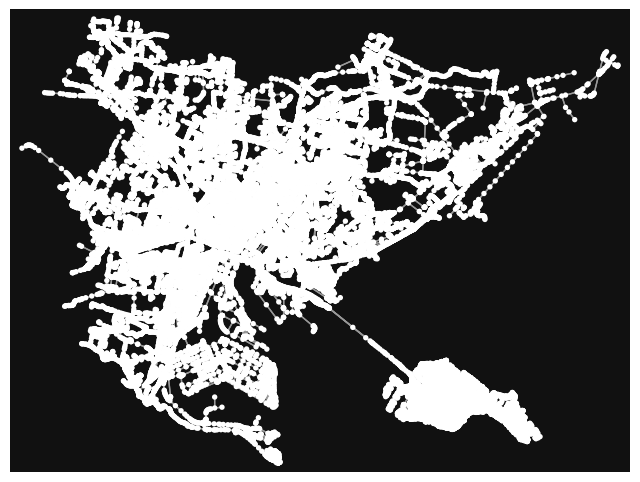

In [140]:
ox.plot_graph(G)
plt.show()

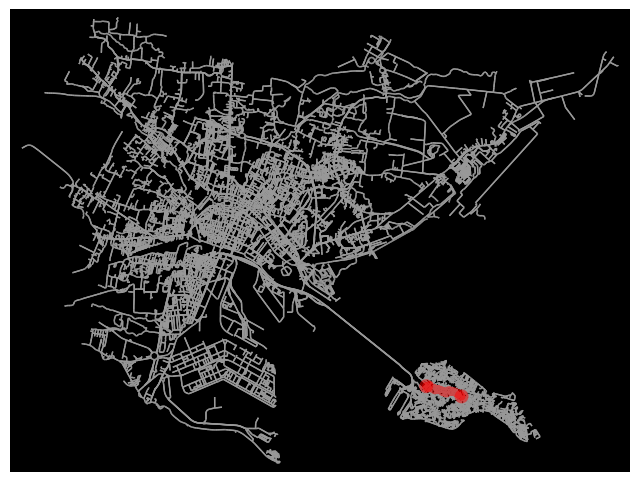

In [141]:
#eg. lenght
route = ox.shortest_path(G, point_nearest_train_station, point_nearest_bridge_rialto, weight='length')
fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')
plt.show()

note:<br/>
you can also use [pandana](http://udst.github.io/pandana/) or [igraph](https://igraph.org/) with [pyrosm](https://pyrosm.readthedocs.io/en/latest/graphs.html)

## Calculate isochornes

In [142]:
trip_times = [3, 6, 9, 15]  # in minutes
travel_speed = 4  # walking speed in km/hour
from shapely.geometry import Point

In [143]:
# we select the train station as center
center_node = point_nearest_train_station
center_node = point_nearest_bridge_rialto

In [144]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for orig,dest, p, data in G_proj.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [145]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G_proj, center_node, radius=trip_time, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)



In [146]:
crs_proj = ox.graph_to_gdfs(G_proj)[0].crs

In [147]:
data = {'trip_time': sorted(trip_times, reverse=True), 'geometry': isochrone_polys}
isochrones = gpd.GeoDataFrame(data,crs=crs_proj)

In [148]:
isochrones.explore(column='trip_time',cmap='Reds')

---

# Exercise

- identify the shortest path by walk to reach the Castle of Trento from the main train station of Trento
- identify the streets network orientation of the cities: Trento-Italy, Verona-Italy,  Munich-Germany, Athens-Greece 
- locate the student residences of Trento in OpenStreetMap and identify services in an area of 15 minutes based on the concept of [Carlos Moreno](https://twitter.com/CarlosMorenoFr) of [the 15 minute city](https://www.ted.com/talks/carlos_moreno_the_15_minute_city)<br/>
<i>"...a way to ensure that urban residents can fulfill six essential functions within a 15-minute walk [or bike] from their dwellings: living, working, commerce, healthcare, education and entertainment..."</i>

You are free to use OSMnx, Pyrosm with networkx or pandas or igraph

